### Architecture of MAS using LangGraph
- Below is the multi-agent system setup done. THis is simple demo to showcase the flow
- Supervisor → DataGatherer → DataCleaner → Reporter → Validator → (Supervisor/END)
- writing this using Langgraph

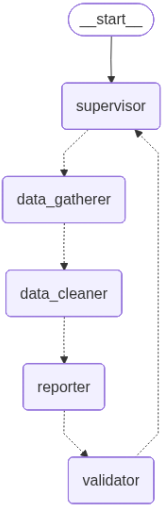

In [ ]:
# Multi-Agent - Build an agent that coordinates with multiple sub-agents to perform complex tasks like gathering data, cleaning it, and creating a report. 


from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant")
from langgraph.graph import StateGraph,MessagesState, END, START
from pydantic import BaseModel, Field
from typing import Literal
from langgraph.types import Command 
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
import pprint

class SupervisorClass(BaseModel):
    next: Literal["data_gatherer"] = Field(
        description="The next agent to route the task to based on current pipeline stage"
    )
    reason: str = Field(
        description="Explanation for why this specific agent was chosen for the next step"
    )

def supervisor_node_fn(state: MessagesState) -> Command[Literal["data_gatherer"]]:
    system_prompt=('''
        You are the Supervisor Agent responsible for coordinating a team of specialized agents:
        - data_gatherer: Collects raw data from various sources
        - data_cleaner: Processes and cleans the gathered data
        - reporter: Creates reports and visualizations from cleaned data
        - Validator: Ensures quality and accuracy of final outputs

        Your objectives are to:
        1. Delegate tasks to appropriate team members
        2. Monitor progress and handle dependencies between agents
        3. Ensure overall quality and completion of the data pipeline
        4. Coordinate communication between agents
        5. Handle any issues or errors that arise
        6. Deliver final validated results ''')
    
    messages=[{"role":"system","content":system_prompt}]+state["messages"]

    response=llm.with_structured_output(SupervisorClass).invoke(messages)
    goto=response.next
    reason=response.reason
    print(f"reason: {reason}")

    print(f"------- Transitioning from Supervisor to {goto}---------")
    return Command(
        update={
            "messages":[HumanMessage(content=reason,name="supervisor")]
        },
        goto=goto,

    )

# Modify data_gatherer_node_fn to add Tavilysearch, also use create_react_agent from langgraph.prebuilt-> invoke the agent -> send only the last message from the result to Command
def data_gatherer_node_fn(state: MessagesState) -> Command[Literal["data_cleaner"]]:
    """
    # write doc string for this

    """
    system_prompt=('''
        You are the data_gatherer Agent responsible for collecting raw data from various sources.
        Your objectives are to:
        1. Gather data from diverse sources
        2. Ensure data quality and completeness
        3. Handle any issues or errors that arise
        4. Deliver raw data to the data_cleaner agent for processing ''')
    
    tools=[TavilySearchResults(max_results=3)]

    data_gatherer_agent=create_react_agent(
        llm,
        tools,
        state_modifier=system_prompt
        )
    result=data_gatherer_agent.invoke(state)

    print("------- Transitioning from data_gatherer to data_cleaner---------")

    return Command(
        update={
            "messages":[HumanMessage(content=result["messages"][-1].content, name="data_gatherer")]
        },
        goto="data_cleaner",
    )

def cleaner_node_fn(state: MessagesState) -> Command[Literal["reporter"]]:
    system_prompt=('''
        You are the data_cleaner Agent responsible for processing and cleaning raw data.
        Your objectives are to:
        1. Clean and format raw data
        2. Ensure data quality and completeness
        3. Handle any issues or errors that arise
        4. Deliver cleaned data to the reporter agent for analysis ''')

    messages=[{"role":"system","content":system_prompt}]+state["messages"]

    response=llm.invoke(messages)
    print("------- Transitioning from data_cleaner to reporter---------")
    return Command(
        update={
            "messages":[HumanMessage(content=response.content, name="data_cleaner")]
        },
        goto="reporter",
    )

def reporter_node_fn(state: MessagesState) -> Command[Literal["validator"]]:
    system_prompt=('''
        You are the reporter Agent responsible for creating reports and visualizations from cleaned data.
        Your objectives are to:
        1. Create reports and visualizations from cleaned data
        2. Ensure data quality and completeness
        3. Handle any issues or errors that arise
        4. Deliver final validated results to the Validator agent for final approval ''')

    messages=[{"role":"system","content":system_prompt}]+state["messages"]

    response=llm.invoke(messages)
    print("------- Transitioning from reporter to Validator---------")
    return Command(
        update={
            "messages":[HumanMessage(content=response.content, name="reporter")]
        },
        goto="validator",
    )
class ValidatorClass(BaseModel):
    next: Literal["supervisor","finish"] = Field(
        description="The next agent to route the task to based on current pipeline stage"
    )
    reason: str = Field(
        description="Explanation for why this specific agent was chosen for the next step"
    )

def validator_node_fn(state: MessagesState) -> Command[Literal["supervisor"]]:
    system_prompt=('''
        You are the Validator Agent responsible for ensuring quality and accuracy of final outputs.
        Your objectives are to:
        1. Ensure quality and accuracy of final outputs
        2. Handle any issues or errors that arise
        3. Deliver final validated results to the user ''')

    user_question = state["messages"][0].content
    cleaned_answer = state["messages"][-1].content
    messages=[
        {"role":"system","content":system_prompt},
        {"role":"user","content":user_question},
        {"role":"assistant","content":cleaned_answer}
    ]
    response=llm.with_structured_output(ValidatorClass).invoke(messages)
    goto=response.next
    reason=response.reason

    if goto=="finish":
        goto = END
        print(f"---- Transitioning to END -------")
    else:
        print(f"------- Transitioning from Validator to {goto}---------")
    
    return Command(
        update={
            "messages":[HumanMessage(content=reason, name="validator")]
        },
        goto=goto,
    )

graph=StateGraph(MessagesState)
graph.add_node("supervisor",supervisor_node_fn)
graph.add_node("data_gatherer", data_gatherer_node_fn)
graph.add_node("data_cleaner", cleaner_node_fn)
graph.add_node("reporter", reporter_node_fn)
graph.add_node("validator", validator_node_fn)

graph.add_edge(START,"supervisor")
myapp=graph.compile()
from IPython.display import Image, display
display(Image(myapp.get_graph(xray=True).draw_mermaid_png())) 

inputs = {
    "messages": [
        ("user", "What is the chennai weather?"),
    ]
}

for event in myapp.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()

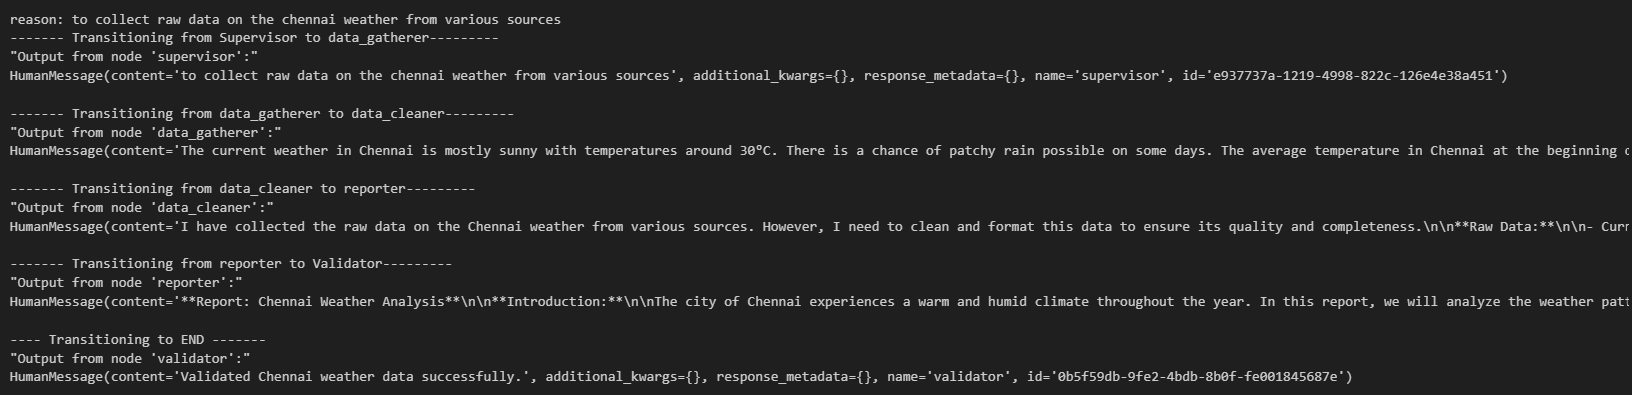